# CytoTRACE

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [2]:
# Load libraries
suppressMessages(library(Seurat))
suppressMessages(library(CytoTRACE))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ggplot2))

In [3]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/seu314/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.1      RColorBrewer_1.1-2 CytoTRACE_0.1.0    Seurat_3.1.5      

loaded via a namespace (and not attached):
 [1] httr_1.4.1         tidyr_1.1.0        jsonlite_1.6.1     viridisLite_0.3.0 
 [5] splines_3.6.1      leiden_0.3.3       ggrepel_0.8.2      globals_0.12.5    
 [9] pi

In [4]:
# Read in the atlas
rc.integrated <- readRDS('./Root_Atlas.rds')

## 1. CytoTRACE

In [5]:
# Since the atlas contains too many cells to be processed by CytoTRACE, we decided to perform CytoTRACE on clusters instead of cells  
# Find nearest neighbors in 50 UMAP dimensions
rc.integrated <- FindNeighbors(rc.integrated, reduction = "umap_50",dims = 1:50)

Computing nearest neighbor graph

Computing SNN



In [6]:
# Clustering with SLM algorithm with resolution 500, which produces ~ 3000 clusters
rc.integrated <- FindClusters(rc.integrated, resolution = 500, algorithm = 3)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 110427
Number of edges: 2611498

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.5994
Number of communities: 2998
Elapsed time: 41 seconds


In [7]:
# Extract integrated (batch-corrected) expression matrix
afm <- rc.integrated@assays$integrated@data

# Pool (average) expression values of each cluster
pooled <- matrix(nrow=nrow(afm), ncol = 0)
for (i in 0:(length(unique(rc.integrated@meta.data$seurat_clusters))-1)) {
m <- afm[,which(rc.integrated@meta.data$seurat_clusters==i)]
pooled <- cbind(pooled, rowSums(m)/ncol(m))
}

In [8]:
# Manually make the expression value non-negative
pooled[which(pooled < 0)]=0

In [9]:
# Set colnames
colnames(pooled) <- as.character(0:(length(unique(rc.integrated@meta.data$seurat_clusters))-1))
str(pooled)

 num [1:17513, 1:2998] 0 0 0 1.68 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:17513] "AT1G05260" "AT3G59370" "AT2G36100" "AT1G12080" ...
  ..$ : chr [1:2998] "0" "1" "2" "3" ...


In [10]:
# Run CytoTRACE
results <- CytoTRACE(pooled, ncores = 16, subsamplesize = 1000)

The number of cells in your dataset is less than 3,000. Fast mode has been disabled.

CytoTRACE will be run on 1 sub-sample(s) of approximately 2998 cells each using 1 / 16 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



In [12]:
# Store CytoTRACE results
new.cluster.ids <- results$CytoTRACE
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated$CytoTRACE <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



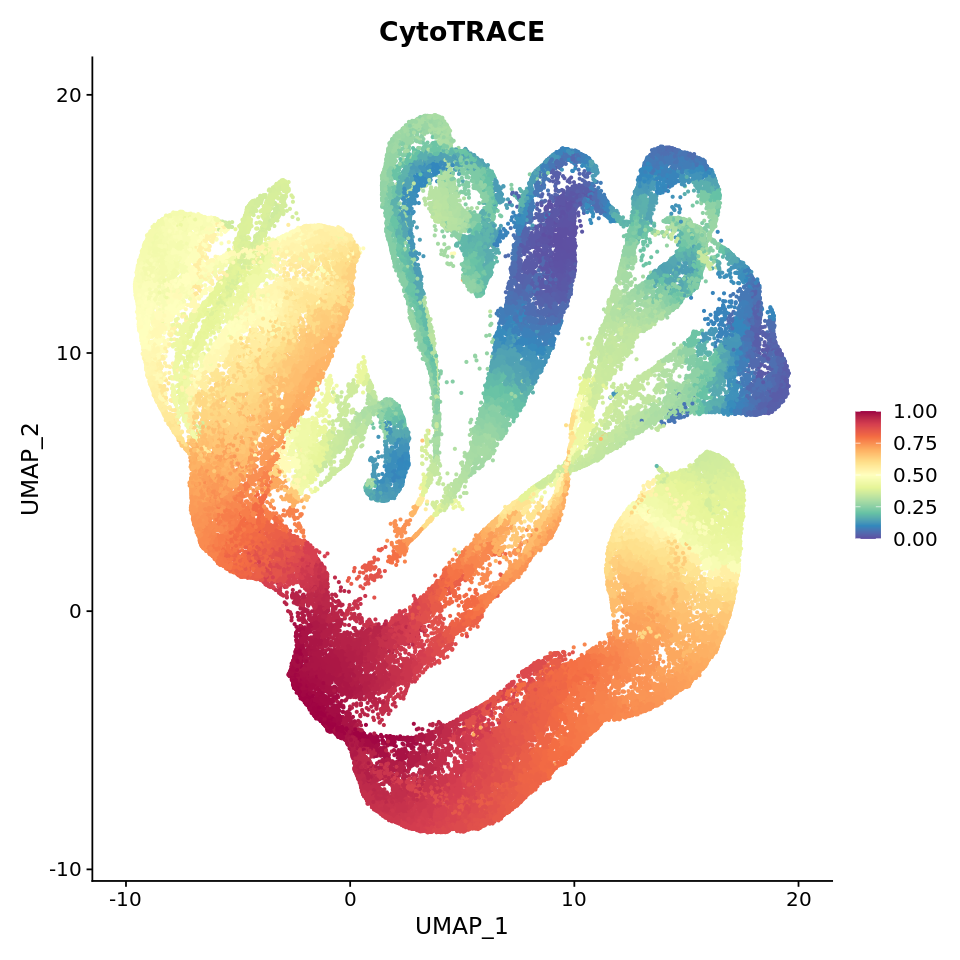

In [13]:
# Plot CytoTRACE
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(rc.integrated, features = "CytoTRACE", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

In [81]:
# Save Seurat object
saveRDS(rc.integrated, file='./Root_Atlas.rds')